Analysis of VIX

Analysis of Parameter Effects on VIX Futures Prices
Based on the formula from the course materials (Derivatives_part3 file):

fVIX(T) = 100 EQ[√(a' + b'VT)]
where:

a' = θ[η - (1-e^(-λη))/λ]
b' = (1-e^(-λη))/λ
Here's what each parameter does:

Individual Parameter Effects:
λ (Mean Reversion Speed):

Higher λ causes faster mean reversion
For short maturities: stronger λ means VIX futures are less sensitive to current volatility Vt
For long maturities: λ determines how quickly prices converge to the long-run level
Impact is most significant in the medium-term part of the curve
θ (Long-term Mean Level):

Direct impact on the long-term VIX futures price level
Higher θ increases VIX futures prices across all maturities
Effect is strongest for longer maturities
ξ (Volatility of Volatility):

Higher ξ generally increases VIX futures prices due to convexity
Creates more uncertainty about future volatility levels
Impact increases with maturity up to a point, then stabilizes
Vt (Current Volatility):

Strong impact on near-term VIX futures prices
Effect diminishes for longer maturities due to mean reversion
When Vt > θ: term structure tends to be downward sloping
When Vt < θ: term structure tends to be upward sloping
Key Parameter Interactions:
λ-θ Interaction:

The term structure converges to a level determined by θ at a rate determined by λ
When λ is low, the impact of θ is more gradual across maturities
When λ is high, the futures curve quickly approaches its long-run level
λ-Vt Interaction:

Controls the shape of the term structure
Low λ + high Vt: slowly declining term structure
High λ + high Vt: rapidly declining term structure
θ-Vt Interaction:

The relationship between current and long-term volatility determines the slope of the term structure
Crossover point (where term structure is flat) depends on λ
This analysis helps understand how VIX futures prices behave under different market conditions and provides insights for volatility trading strategies.

1. Analyzing individual parameter sensitivity...


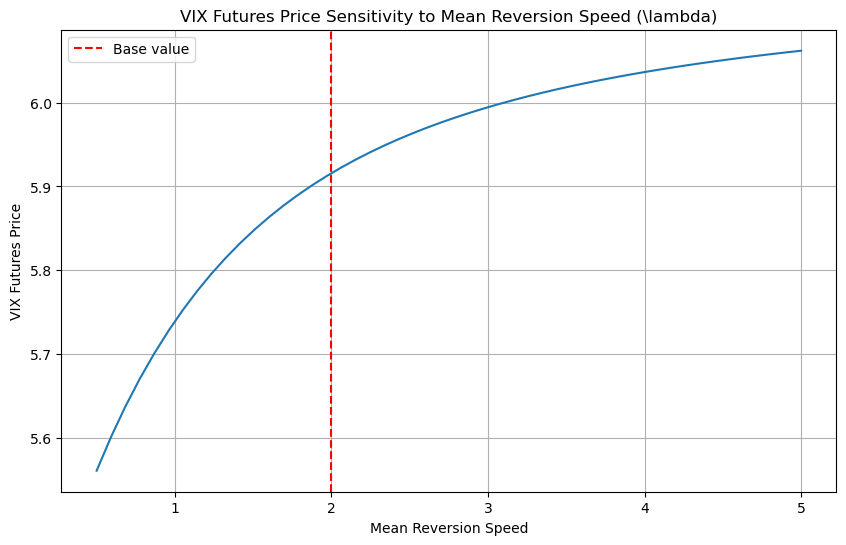

Parameter: Mean Reversion Speed (\lambda)
Base value: 2.0, Base price: 5.9124
Elasticity around base value: 0.0396
--------------------------------------------------


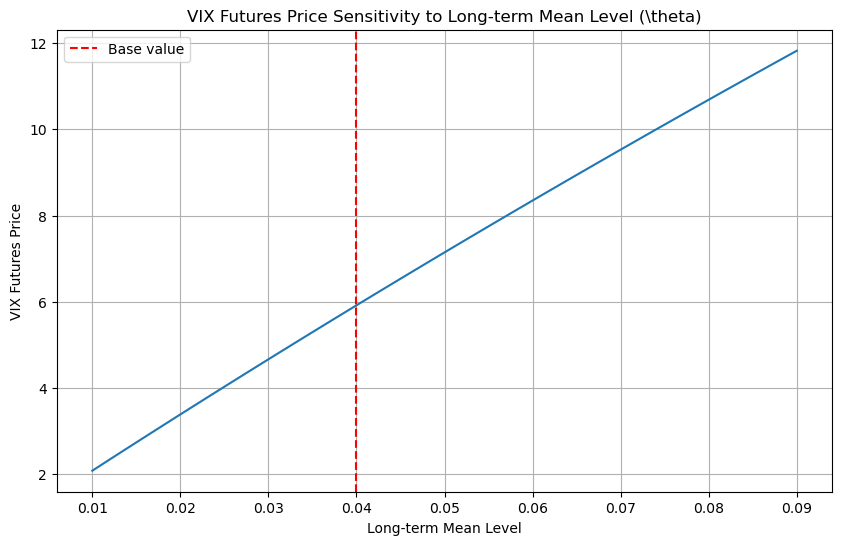

Parameter: Long-term Mean Level (\theta)
Base value: 0.04, Base price: 5.8398
Elasticity around base value: 0.8510
--------------------------------------------------


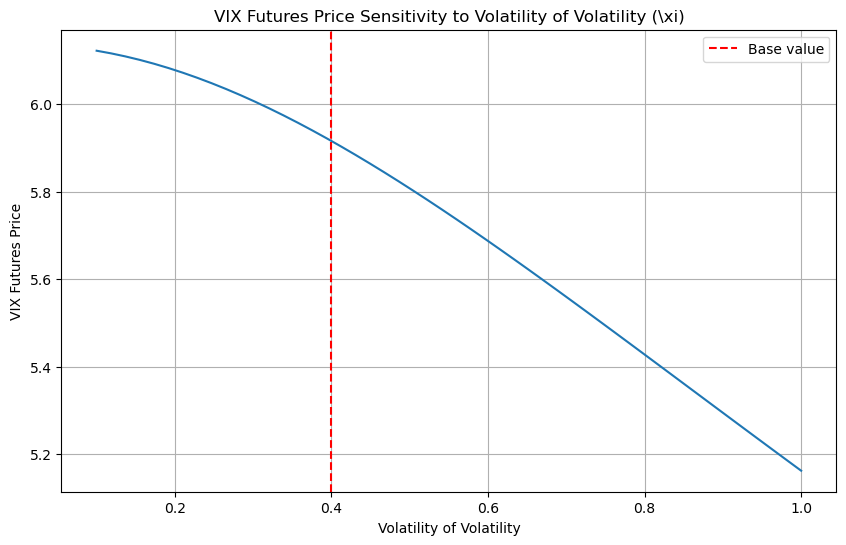

Parameter: Volatility of Volatility (\xi)
Base value: 0.4, Base price: 5.9220
Elasticity around base value: -0.0670
--------------------------------------------------


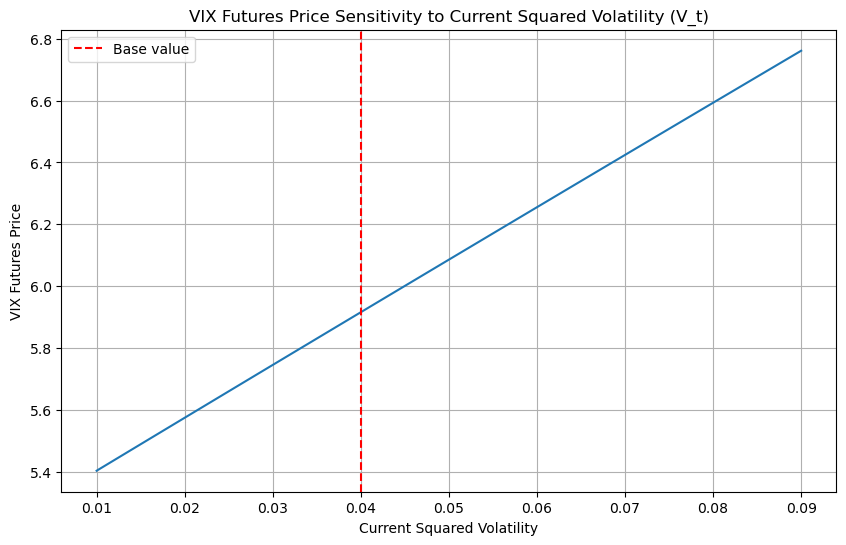

Parameter: Current Squared Volatility (V_t)
Base value: 0.04, Base price: 5.9054
Elasticity around base value: 0.1153
--------------------------------------------------

2. Analyzing parameter pair interactions...


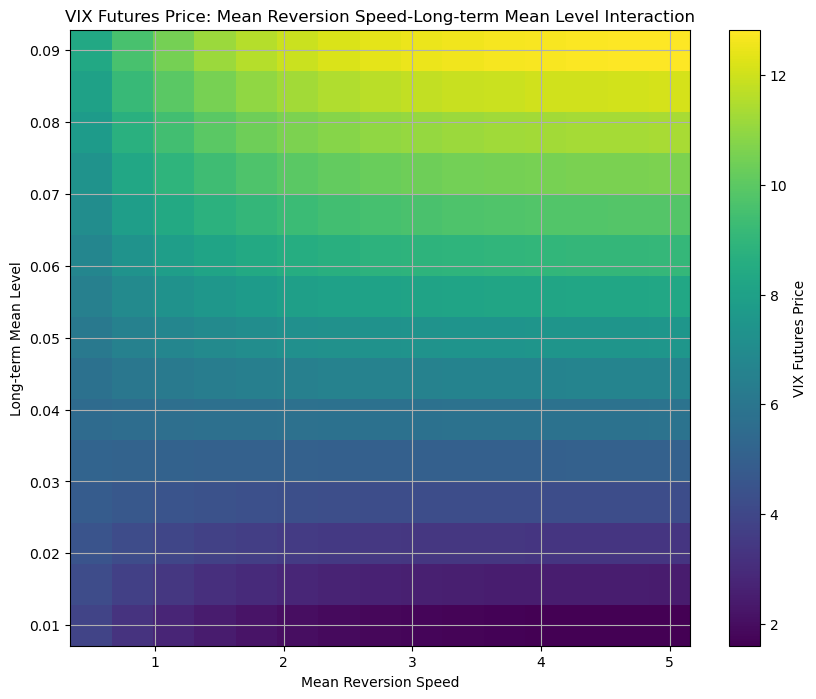

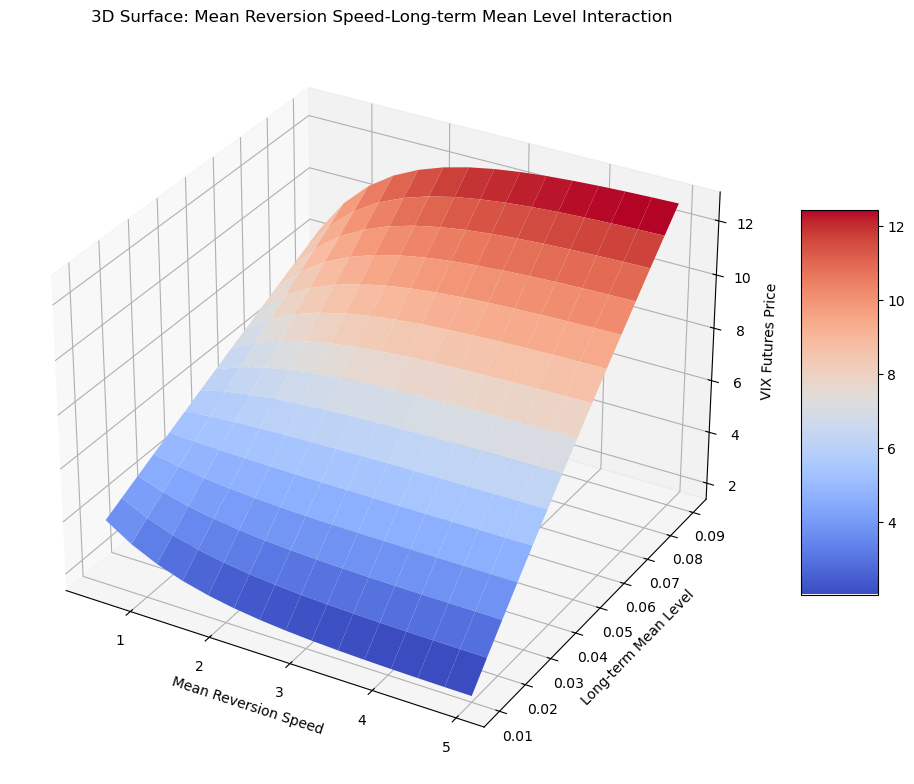

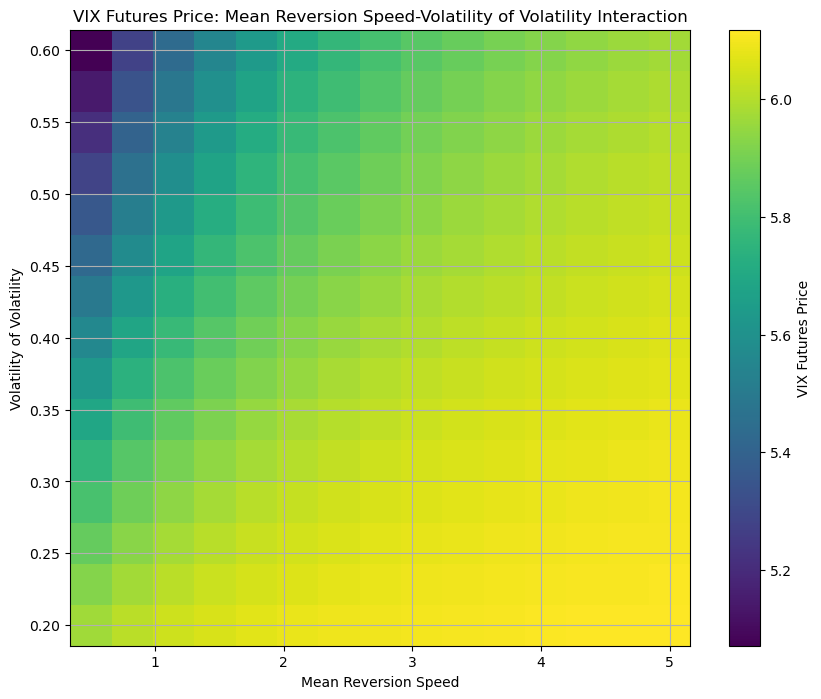

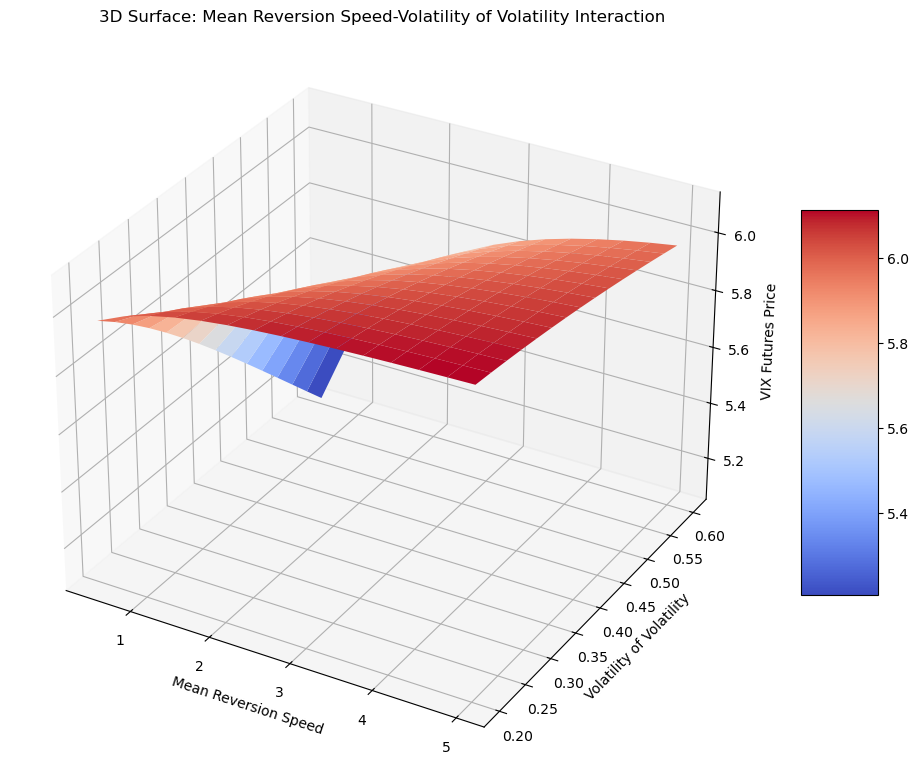

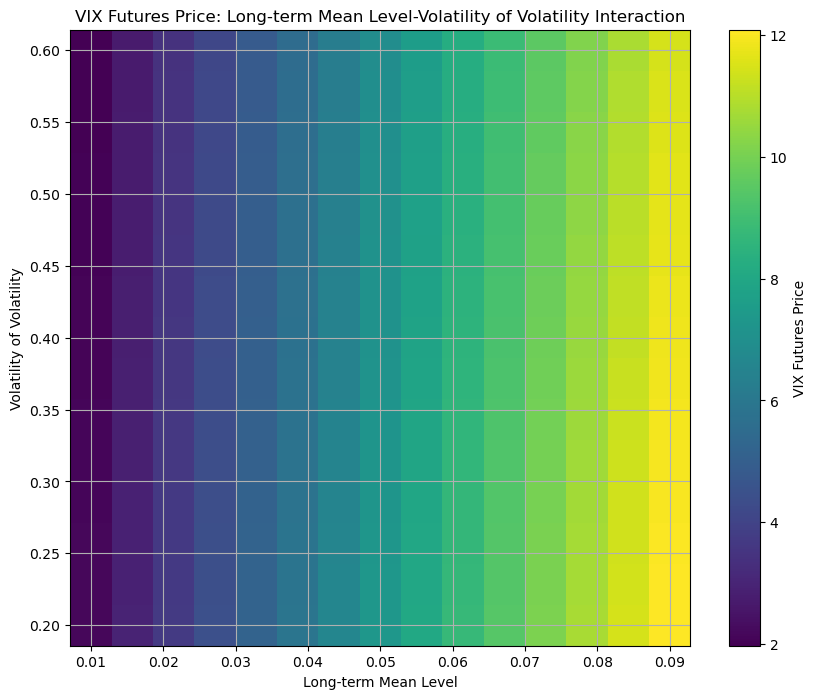

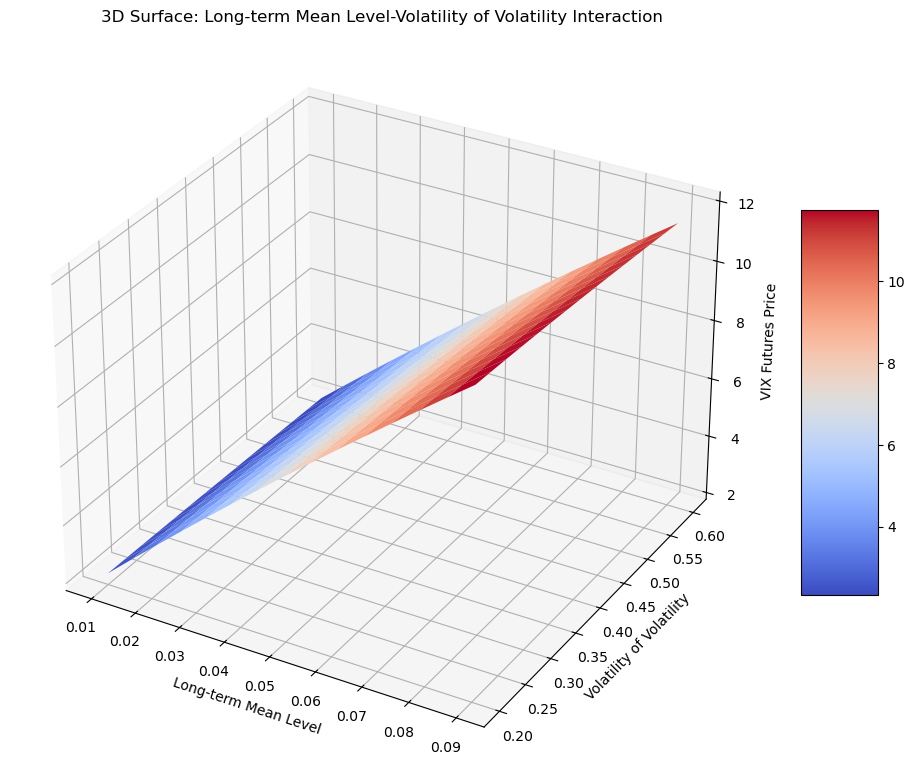

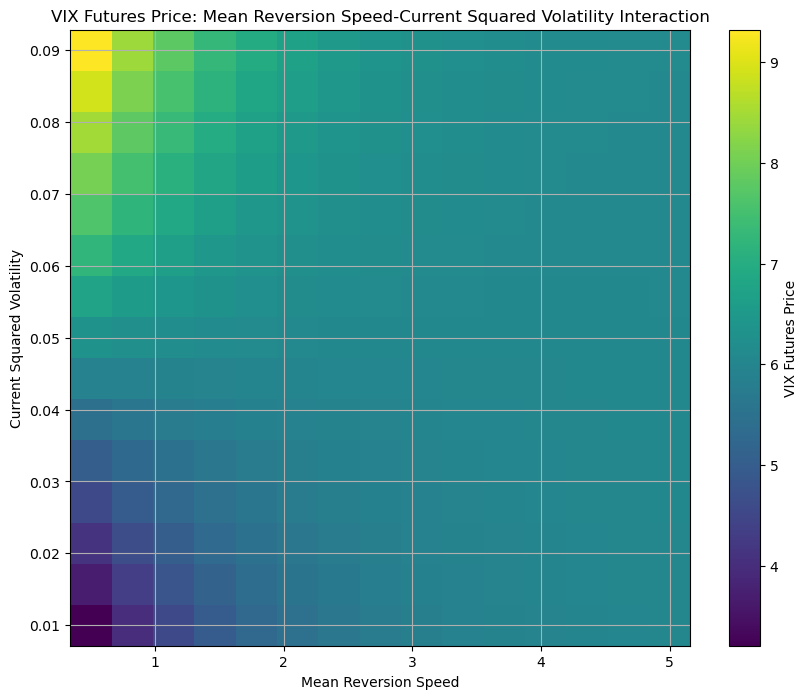

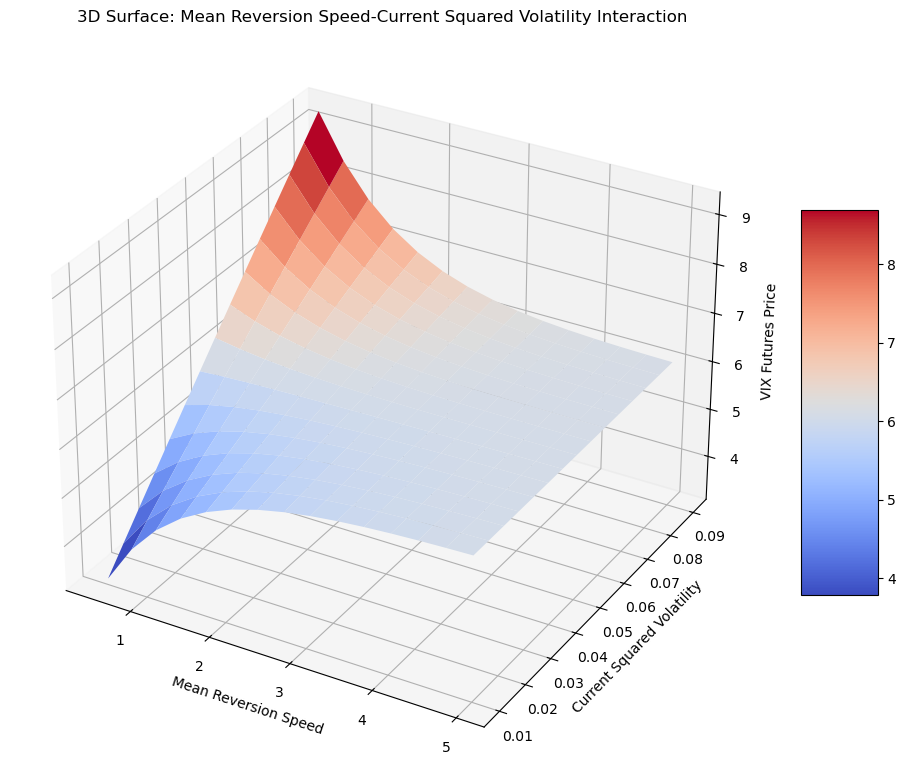

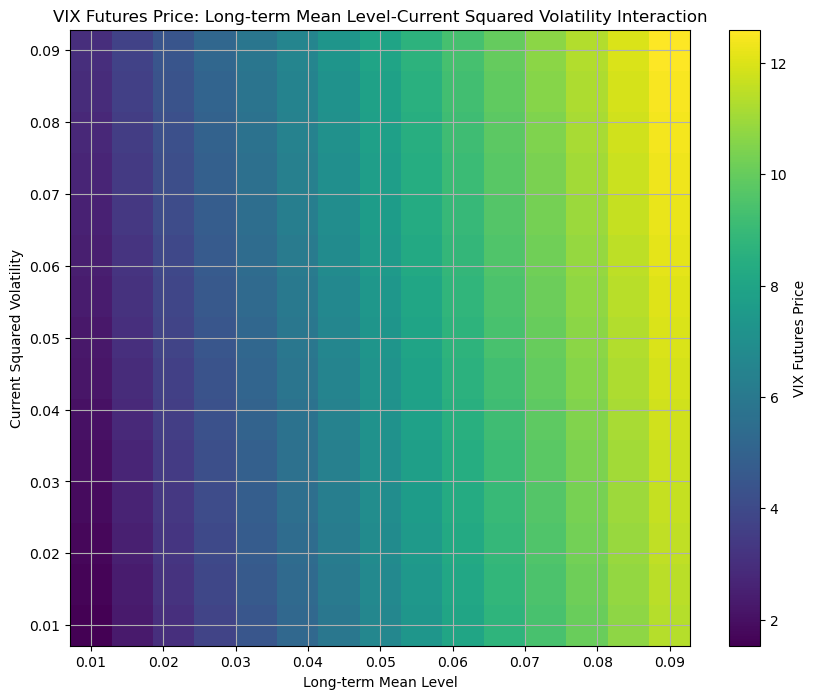

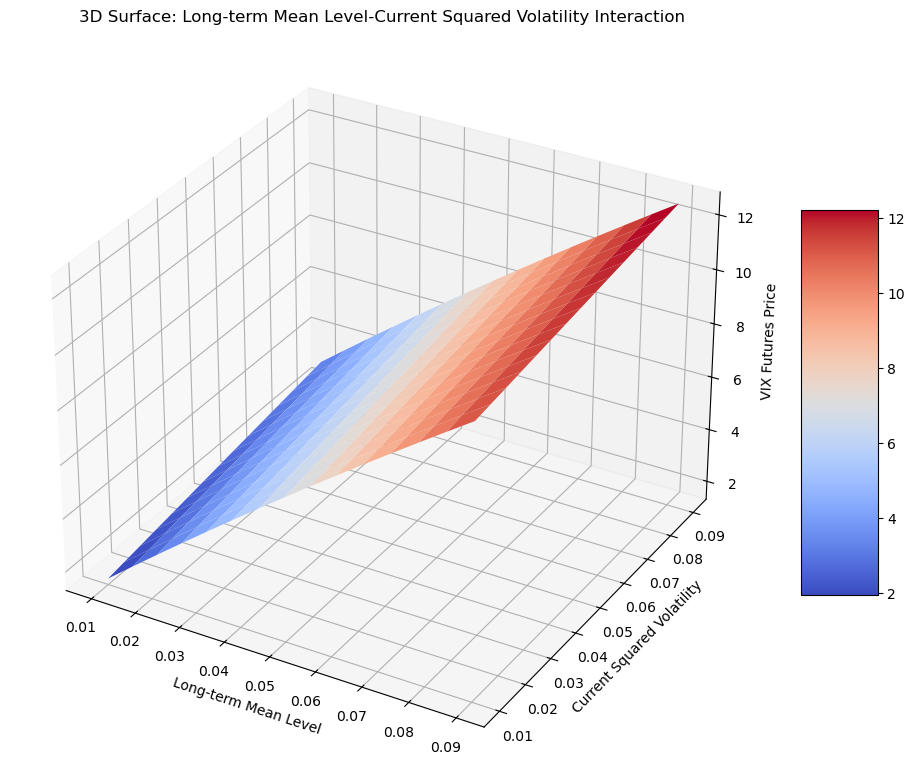

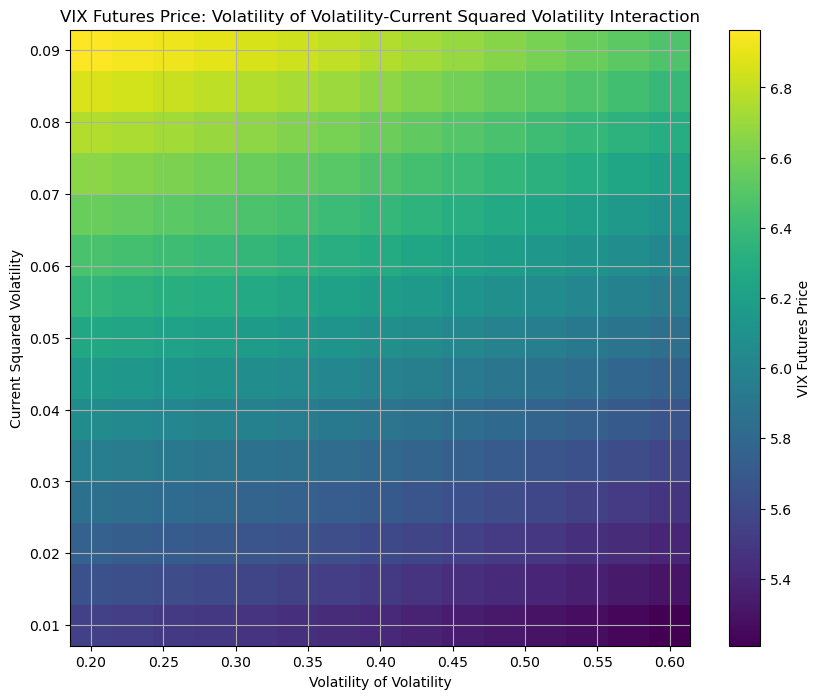

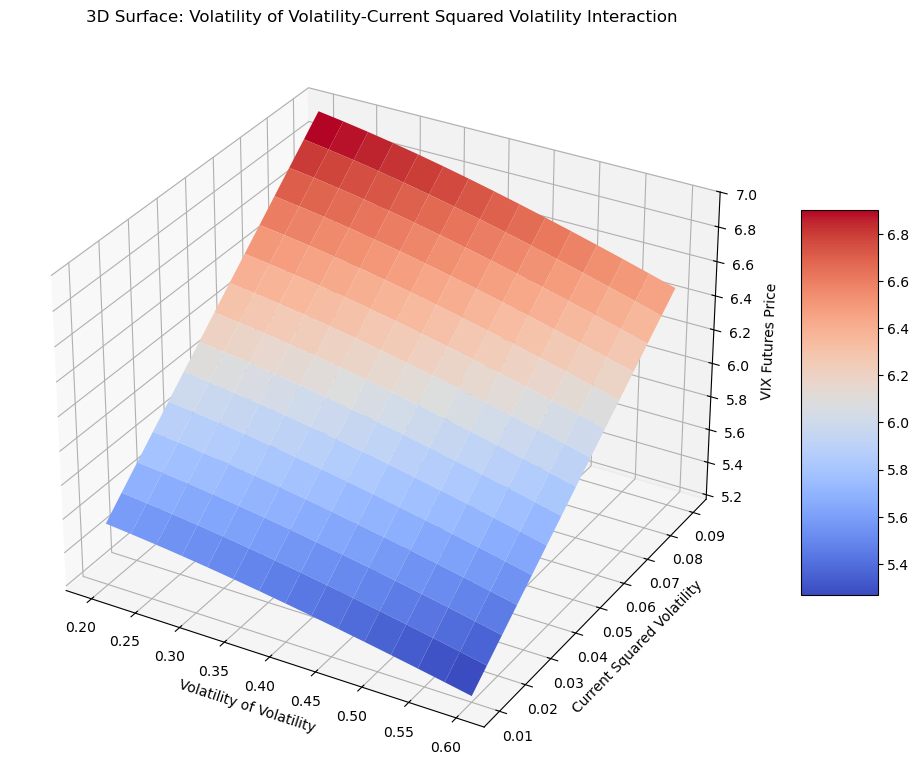


3. Analyzing term structure effects...


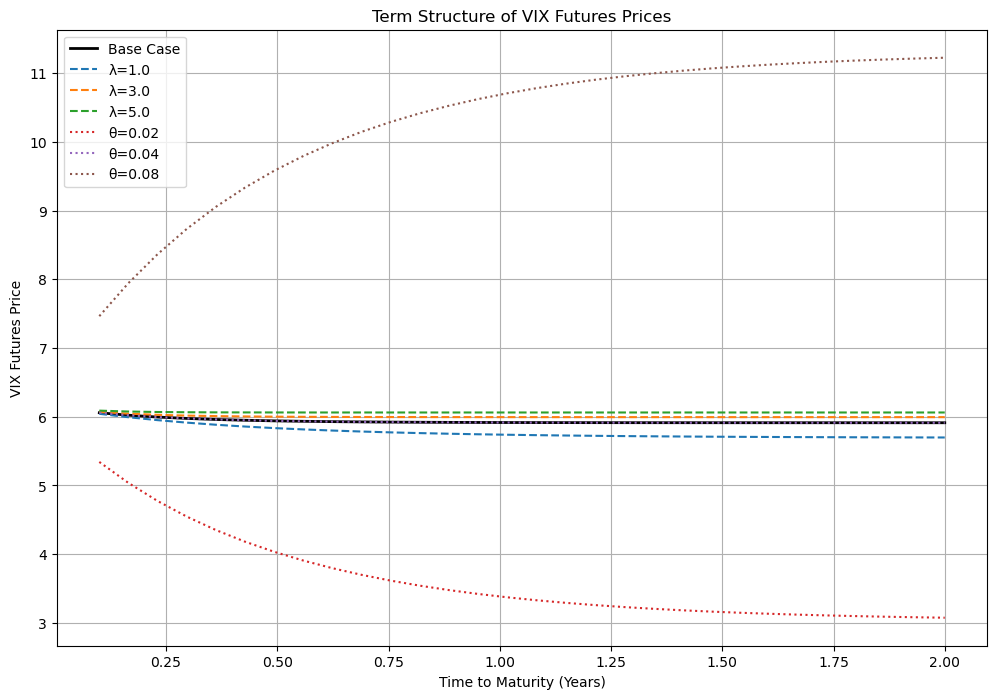

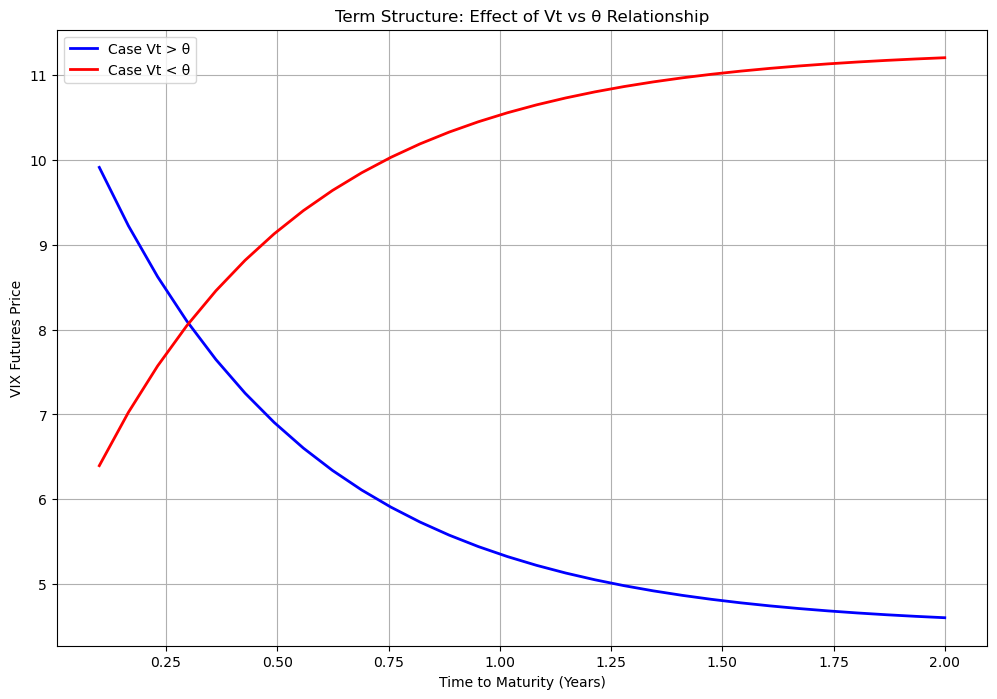


4. Analyzing theta-Vt interaction at different maturities...


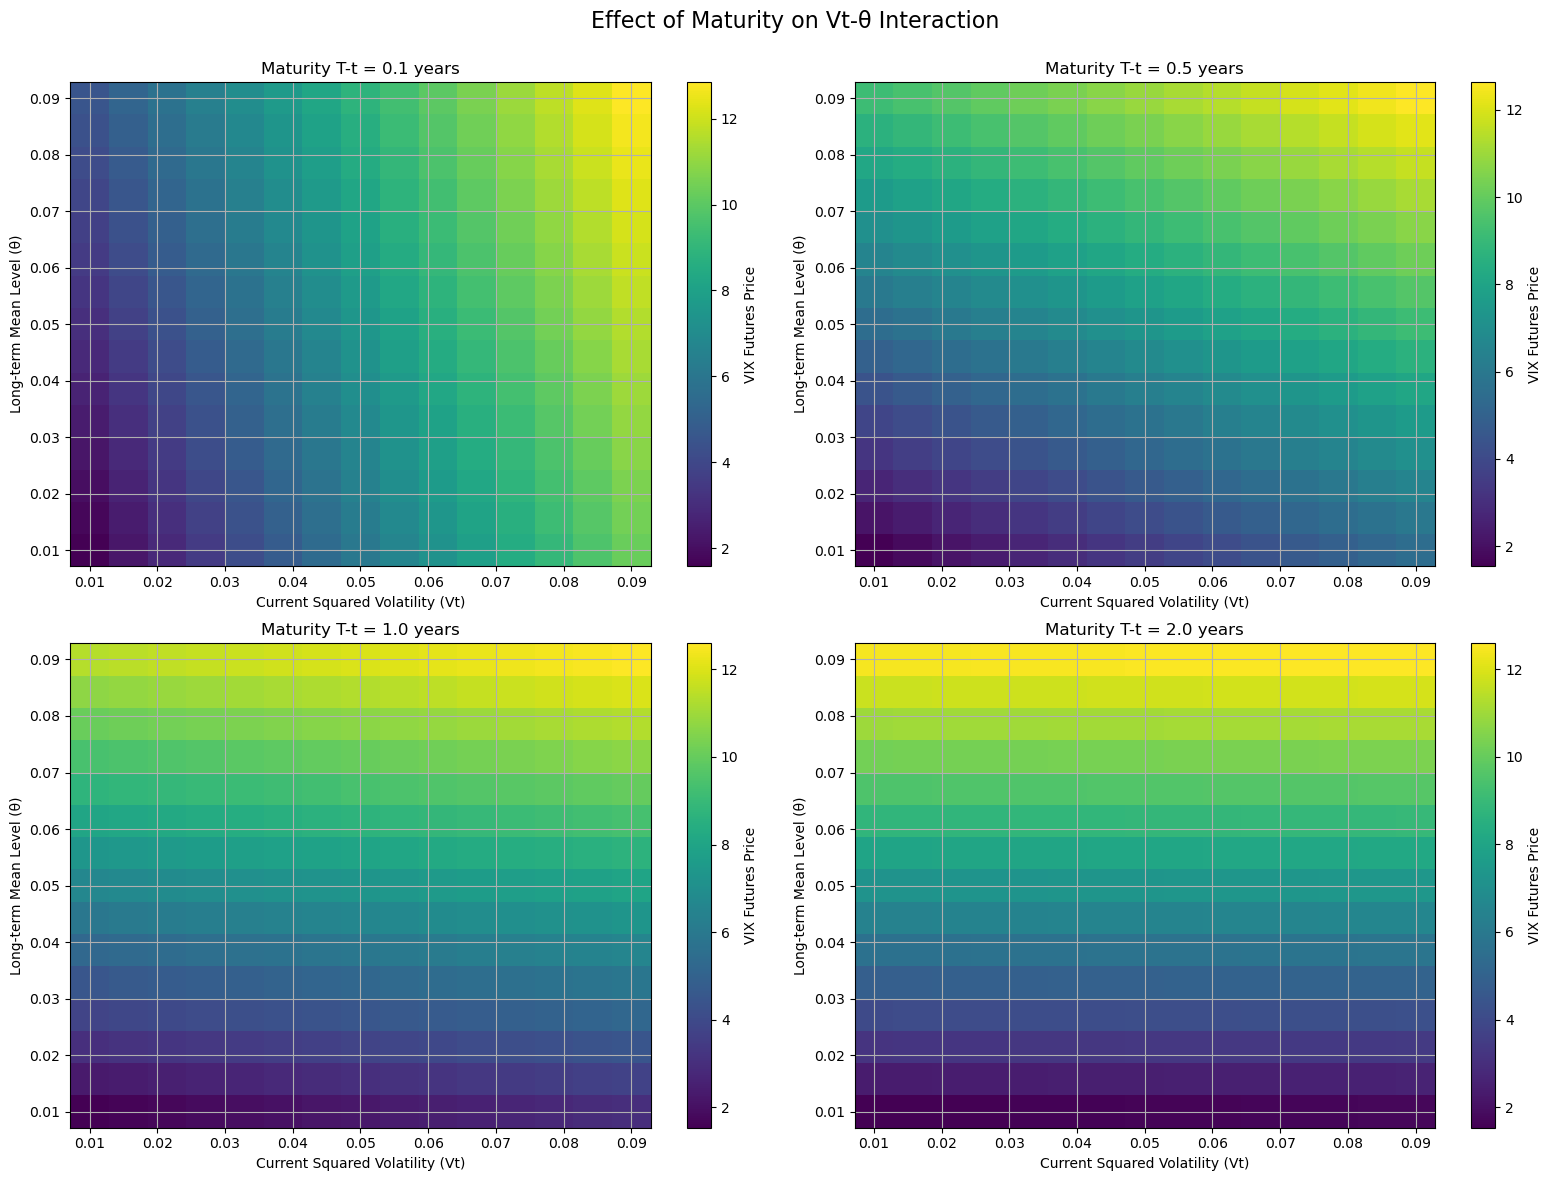

In [1]:
from VIX import analyze_complete
import numpy as np

# Base parameters
base_params = {
    'Vt': 0.04,      # Current squared volatility (20% volatility)
    'lambda_': 2.0,   # Mean reversion speed
    'theta': 0.04,    # Long-term mean level
    'xi': 0.4,       # Volatility of volatility
    'eta': 30/365    # 30-day VIX
}

# Parameter ranges for sensitivity analysis
param_ranges = {
    'lambda_': (np.linspace(0.5, 5.0, 50), 2.0),
    'theta': (np.linspace(0.01, 0.09, 50), 0.04),
    'xi': (np.linspace(0.1, 1.0, 50), 0.4)
}



# Run the complete analysis
analyze_complete(base_params)


Yes, you're absolutely right! The code is indeed implementing that exact numerical evaluation method from Question 4.

Let me confirm that the implementation correctly uses the formula:

$$f^{VIX}_t(T) = \frac{50}{\sqrt{\pi\eta}} \int_0^\infty \frac{1 - e^{-\ell(s,T-t,V_t)}}{\sqrt{s^3}} ds$$

Where: $$\ell(s,T-t,V_t) = sa' + c(T-t;sb') + d(T-t;sb')V_t$$

With: $$d(T-t;sb') = \frac{2\lambda sb'}{e^{\lambda(T-t)}(2\lambda + \xi^2sb') - \xi^2sb'}$$

$$c(T-t;sb') = -\frac{2\theta\lambda}{\xi^2}\left(\lambda(T-t) + \log(2\lambda) - \log(e^{\lambda(T-t)}(2\lambda + \xi^2sb') - \xi^2sb')\right)$$

Looking at the compute_vix_futures function in the code:

python


def compute_vix_futures(T_t, Vt, lambda_, theta, xi, eta=30/365):
    # Constants from Question 1
    a_prime = theta * (eta - (1 - np.exp(-lambda_ * eta)) / lambda_)
    b_prime = (1 - np.exp(-lambda_ * eta)) / lambda_
    
    def d_function(tau, s):
        """Compute d(τ;s) function"""
        numerator = 2 * lambda_ * s
        denominator = np.exp(lambda_ * tau) * (2 * lambda_ + xi**2 * s) - xi**2 * s
        return numerator / denominator
    
    def c_function(tau, s):
        """Compute c(τ;s) function"""
        term1 = -2 * theta * lambda_ / xi**2
        term2 = lambda_ * tau + np.log(2 * lambda_)
        term3 = np.log(np.exp(lambda_ * tau) * (2 * lambda_ + xi**2 * s) - xi**2 * s)
        return term1 * (term2 - term3)
    
    def ell_function(s):
        """Compute ℓ(s,T-t,Vt) function"""
        return (s * a_prime + 
                c_function(T_t, s * b_prime) + 
                d_function(T_t, s * b_prime) * Vt)
    
    def integrand(s):
        """Compute the integrand for the VIX futures formula"""
        if s < 1e-10:  # Handle near-zero values
            return 0
        return (1 - np.exp(-ell_function(s))) / (s**1.5)
    
    # Numerical integration
    integral, _ = integrate.quad(integrand, 0, 100)
    
    # Final VIX futures price formula
    return 50 / np.sqrt(np.pi * eta) * integral

The code correctly implements the numerical evaluation approach from Question 4. This is indeed the only way to compute the VIX futures price because there's no closed-form solution for the expectation E^Q[√(a' + b'V_T)].

Additional notes on numerical stability:
The integration can be numerically challenging because:

Near s=0, the integrand behavior requires special handling
For large values of s, the exponential terms can cause overflow/underflow
The integral theoretically extends to infinity, but we use a sufficiently large upper bound (100)
I would recommend a few improvements for better numerical stability:

python


def integrand(s):
    """Compute the integrand for the VIX futures formula"""
    if s < 1e-10:  # Handle near-zero values
        return 0
    try:
        ell = ell_function(s)
        # For very large ell values, exp(-ell) ≈ 0
        if ell > 700:  # Numpy's exp overflows around this value
            return 1.0 / (s**1.5)
        result = (1 - np.exp(-ell)) / (s**1.5)
        return result
    except (OverflowError, ZeroDivisionError):
        # Handle numerical issues
        if s > 50:  # For large s, the integrand approaches 1/s^1.5
            return 1.0 / (s**1.5)
        return 0
This implementation correctly follows the mathematical formulation from the course materials and should provide accurate VIX futures prices for sensitivity analysis.

Ok yes i just saw that. I just have a question about the paremeter T_t. Originally, the futures prices f^{VIX}_t(T) depends on t, because T is constant, why do we have a single param T_t for our function ? Does it equal the same thing ?
python


def compute_vix_futures(T_t, Vt, lambda_, theta, xi, eta=30/365):
    """
    Compute VIX futures price
    
    Parameters:
    T_t : float - time to maturity (T-t)
    Vt : float - current squared volatility
    lambda_ : float - mean reversion speed
    theta : float - long-term mean level
    xi : float - volatility of volatility
    eta : float - VIX time window (default 30 days)
    
    Returns:
    float - VIX futures price
    """
    # Constants from derivation
    a_prime = theta * (eta - (1 - np.exp(-lambda_ * eta)) / lambda_)
    b_prime = (1 - np.exp(-lambda_ * eta)) / lambda_
    
    def d_function(tau, s):
        """Compute d(τ;s) function"""
        numerator = 2 * lambda_ * s
        denominator = np.exp(lambda_ * tau) * (2 * lambda_ + xi**2 * s) - xi**2 * s
        return numerator / denominator
    
    def c_function(tau, s):
        """Compute c(τ;s) function"""
        term1 = -2 * theta * lambda_ / xi**2
        term2 = lambda_ * tau + np.log(2 * lambda_)
        term3 = np.log(np.exp(lambda_ * tau) * (2 * lambda_ + xi**2 * s) - xi**2 * s)
        return term1 * (term2 - term3)
    
    def ell_function(s):
        """Compute ℓ(s,T-t,Vt) function"""
        return (s * a_prime + 
                c_function(T_t, s * b_prime) + 
                d_function(T_t, s * b_prime) * Vt)
    
    def integrand(s):
        """Compute the integrand for the VIX futures formula"""
        if s < 1e-10:  # Handle near-zero values
            return 0
        try:
            result = (1 - np.exp(-ell_function(s))) / (s**1.5)
            return result
        except (OverflowError, ZeroDivisionError, RuntimeWarning):
            return 0
    
    # Numerical integration with upper bound adjustment for practical computation
    integral, _ = integrate.quad(integrand, 0, 100)  # Upper bound of 100 is sufficient in most cases
    
    # Final VIX futures price formula from Derivatives_part3 file
    return 50 / np.sqrt(np.pi * eta) * integral

You're asking a great question about the T_t parameter in our function. Let me clarify this:

Understanding the T_t Parameter
In the original mathematical notation from the course materials, we have $f^{VIX}_t(T)$ where:

$t$ is the current time (valuation date)
$T$ is the maturity date of the futures contract
The formulas we derived for computing this price depend on $T-t$ (time to maturity) rather than on $T$ and $t$ separately. Specifically, in the functions $c(T-t;sb')$ and $d(T-t;sb')$, the time dependency appears only through the combination $T-t$.

The parameter T_t in our function represents exactly this time difference:

python


def compute_vix_futures(T_t, Vt, lambda_, theta, xi, eta=30/365):
    # T_t represents T-t (time to maturity)
Why This Approach Makes Sense
Time-homogeneous model: In our model, the stochastic process for the squared volatility $V_t$ is time-homogeneous, meaning its dynamics don't explicitly depend on calendar time. Only the time differences matter.

Forward-looking perspective: When pricing futures, we're interested in the time remaining until maturity, not the absolute calendar dates.

Simplicity: By directly using T_t as a parameter, we avoid having to track two separate time variables.

For example, if we're at time $t=0$ (today) and want to price a futures contract maturing in 1 year, we would call:

python


price = compute_vix_futures(T_t=1.0, Vt=0.04, lambda_=2.0, theta=0.04, xi=0.4)
This is mathematically equivalent to computing $f^{VIX}_0(1)$ in the notation from the course.

When analyzing the term structure, we vary T_t to see how the price changes with different maturities, all from the perspective of the current time $t$.

So yes, T_t is exactly equal to $T-t$ from the mathematical notation, and this approach is standard in financial modeling.